### Grapevine Leaves Image Dataset
- GoogLeNet with BatchNorm Layers in Inception Block.
- With Cosine Scheduler

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.utils.data as data
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import matplotlib_inline
from torch.optim import lr_scheduler

In [2]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device("cpu")

### Load Data

In [3]:
transform = transforms.Compose(
    [transforms.Resize(512),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
main_folder = "/openbayes/input/input1/Grapevine_Leaves_Image_Dataset"

In [4]:
# split train and test dataset
def dataset_split(dataset, test_percentage=0.2):
    test_size = int(len(dataset) * test_percentage/2)
    train_size = len(dataset) - test_size*2
    cal_size = len(dataset) - train_size - test_size
    train_data, test_data, cal_data = data.random_split(dataset, [train_size, test_size,cal_size])
    return (train_data, test_data, cal_data)

batch_size, test_percentage = 32, 0.2
data_all = torchvision.datasets.ImageFolder(root=main_folder, transform=transform)
train_data,test_data,cal_data = dataset_split(data_all,test_percentage)
train_iter = data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
test_iter = data.DataLoader(test_data, batch_size=batch_size, num_workers=0)
cal_iter = data.DataLoader(cal_data, batch_size=batch_size, num_workers=0)

### Set GoogLeNet With BatchNorm Layer

In [5]:
class Inception(nn.Module):
    def __init__(self, in_channels, C1, C2, C3, C4, **kwargs):
        super().__init__()
        self.p1_1 = nn.Conv2d(in_channels, C1, kernel_size=1)
        self.p1_2 = nn.BatchNorm2d(C1)
        self.p2_1 = nn.Conv2d(in_channels, C2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(C2[0], C2[1], kernel_size=3, padding=1)
        self.p2_3 = nn.BatchNorm2d(C2[1])
        self.p3_1 = nn.Conv2d(in_channels, C3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(C3[0], C3[1], kernel_size=5, padding=2)
        self.p3_3 = nn.BatchNorm2d(C3[1])
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, C4, kernel_size=1)
        self.p4_3 = nn.BatchNorm2d(C4)

    def forward(self, X):
        o1 = F.relu(self.p1_2(self.p1_1(X)))
        o2 = F.relu(self.p2_3(self.p2_2(F.relu(self.p2_1(X)))))
        o3 = F.relu(self.p3_3(self.p3_2(F.relu(self.p3_1(X)))))
        o4 = F.relu(self.p4_3(self.p4_2(self.p4_1(X))))
        return torch.cat([o1, o2, o3, o4], dim=1)
    
class Google_net(nn.Module):
    def __init__(self, in_channels, Inception):
        super().__init__()
        b1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=7, padding=3, stride=2), nn.BatchNorm2d(64),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                          nn.Conv2d(64, 64, kernel_size=1),nn.BatchNorm2d(64),
                          nn.ReLU(),
                          nn.Conv2d(64, 192, kernel_size=3, padding=1),nn.BatchNorm2d(192),
                          nn.ReLU(),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        b2 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                           Inception(256, 128, (128, 192), (32, 96), 64),
                           nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        b3 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        
        b4 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())
        self.net = nn.Sequential(b1, b2, b3, b4, nn.Dropout(0.3), nn.Linear(1024, 512), nn.Dropout(0.5), nn.Linear(512, 5)) 
    
    def forward(self, X):
        return(self.net(X))
    
def init_parameters(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

### Functions to Evaluate the Accuracy of the Model

In [6]:
class Accumulator():
    def __init__(self, size):
        self.size = size
        self.counter = [0] * size
    
    def __getitem__(self, idx):
        return self.counter[idx]
    
    def set_zeros(self):
        self.counter = [0] * len(self.counter)
    
    def add(self, *nums):
        assert len(nums) == len(self.counter), "Different numbers of numbers and accumulator size."
        self.counter = [i + num for i,num in zip(self.counter, nums)]

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(dim=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            metric.add(accuracy(y_hat,y), y.numel())
    return metric[0] / metric[1]

### Functions to Generate the Plot of Loss and Accuracy in Animation

In [7]:

class Animator:
    def __init__(self, xlabels=None, ylabels=None, legends=None, xlims=None,
                 ylims=None, xscales='linear', yscales='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(4, 6)):
        # Incrementally plot multiple lines
        self.num_argument = len(xlabels) if xlabels is not None else 0
        self.plot_arguments = [xlabels, ylabels, xlims, ylims, xscales, yscales, legends]
        for i in range(len(self.plot_arguments)):
            if self.plot_arguments[i] is None:
                self.plot_arguments[i] = [None] * self.num_argument
        self.plot_arguments = list(zip(*self.plot_arguments))
        matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
        
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
            
        self.X, self.Y, self.fmts = None, None, fmts
    
    def set_axes(self, axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()
            
    def add(self, xs, ys):
        # Add multiple data points into the figure
        if not self.X:
            self.X = [[]] * self.num_argument
        if not self.Y:
            self.Y = [[]] * self.num_argument

        for i, (x, y) in enumerate(zip(xs, ys)):
            if not hasattr(y, "__len__"):
                y = [y]
            n = len(y)
            if not hasattr(x, "__len__"):
                x = [x] * n
                
            if self.X[i] == []:
                self.X[i] = [[]] * n
            if self.Y[i] == []:
                self.Y[i] = [[]] * n

            for t, (a, b) in enumerate(zip(x, y)):
                if a is not None and b is not None:
                    self.X[i][t] = [*self.X[i][t],a]
                    self.Y[i][t] = [*self.Y[i][t],b]
            self.axes[i].cla()
            for m, n, fmt in zip(self.X[i], self.Y[i], self.fmts):
                self.axes[i].plot(m, n, fmt)
            self.set_axes(self.axes[i], *self.plot_arguments[i])
        display.display(self.fig)
        display.clear_output(wait=True)

### Train

In [8]:
def train(net, train_iter, test_iter, num_cpochs, begin_lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print("training on", device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=begin_lr)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min = 0.001)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabels=['epoch', 'epoch'],
                        xlims=[[1, num_epochs], [1, num_epochs]],
                        xscales=['linear','linear'],
                        yscales=['linear','linear'],
                        legends=[['train loss'], ['train acc', 'test acc']],
                        nrows=2, ncols=1)
    num_batches = len(train_iter)
    
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 2) == 0 or  i == num_batches - 1 :
                animator.add((epoch + (i + 1) / num_batches, epoch + (i + 1) / num_batches),
                             (float(train_l), (float(train_acc), None)))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add((epoch + 1, epoch + 1), (None, (None, test_acc)))
        scheduler.step()

    print(f'{num_epochs} epochs training')
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, ')
    print(f'test acc {test_acc:.3f}')

In [9]:
net = Google_net(3, Inception)
num_epochs, begin_lr = 30, 0.05

#### This step can be skipped, becuase the model weight has been saved, move to next cell and run it if the time is not enough for you

In [ ]:
train(net, train_iter, test_iter, num_epochs, begin_lr, try_gpu())
torch.save(net.state_dict(),"/openbayes/home/Grapevine_Leaves/model.pth")    

### Loading model weight

In [10]:
model_path = '/openbayes/home/Grapevine_Leaves/model.pth'
net.load_state_dict(torch.load(model_path))
model_Grapevine_Leaves = net

In [15]:
from torchcp.classification.scores import THR, APS, SAPS, RAPS
from torchcp.classification.predictors import ClassWisePredictor

# Preparing a calibration data and a test data.
cal_dataloader = cal_iter
test_dataloader = test_iter
# Preparing a pytorch model
model = model_Grapevine_Leaves

model.eval()

score_functions = [THR(), APS()]
coverage_rates = []
average_sizes = []
# Options of score function: THR, APS, SAPS, RAPS
# Define a conformal prediction algorithm. Optional: SplitPredictor, ClusterPredictor, ClassWisePredictor
for score in score_functions:
    predictor = ClassWisePredictor(score_function=score, model=model)

# Calibrating the predictor with significance level as 0.1
    predictor.calibrate(cal_dataloader, alpha=0.1)

#########################################
# Predicting for test instances
########################################
# for batch in test_dataloader:
#    test_instances , _ = batch
#    predict_sets = predictor.predict(test_instances)
#    print(predict_sets)

#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
    result_dict = predictor.evaluate(test_dataloader)
    coverage_rates.append(result_dict["Coverage_rate"])
    average_sizes.append(result_dict["Average_size"])
    print(result_dict["Coverage_rate"], result_dict["Average_size"])

SyntaxError: invalid syntax (627832215.py, line 18)

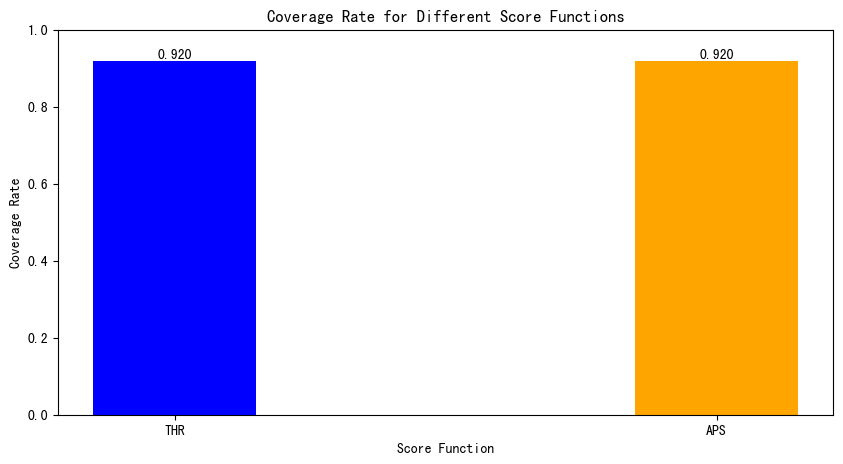

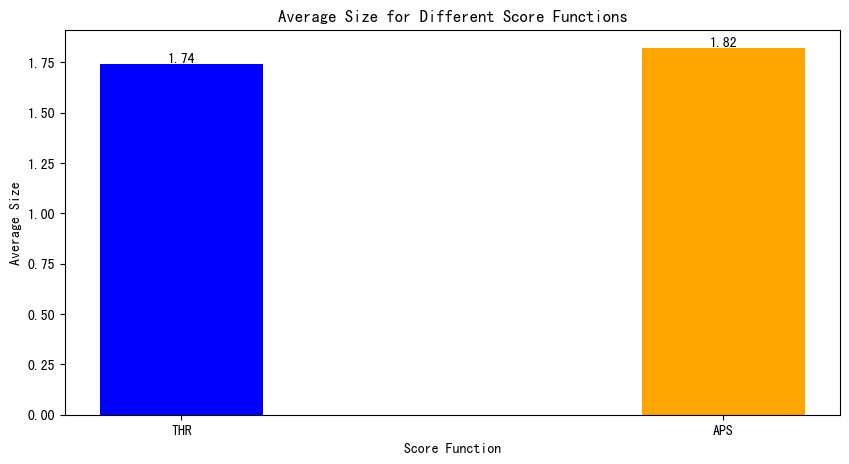

In [16]:
# Assuming you have data for different score functions, Coverage_rate, and Average_size
score_functions = ['THR', 'APS']

# Create a DataFrame for easier plotting

# 绘制Coverage_rate图表
plt.figure(figsize=(10, 5))
bars = plt.bar(score_functions, coverage_rates, color=['blue', 'orange'], width=0.3)
plt.title('Coverage Rate for Different Score Functions')
plt.xlabel('Score Function')
plt.ylabel('Coverage Rate')
plt.ylim(0, 1)  # 设置y轴范围为0到1

# 在每个柱状图上显示相应的值
for bar, value in zip(bars, coverage_rates):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.3f}', ha='center', va='bottom')
plt.savefig('/openbayes/home/Grapevine_Leaves/Grapevine_Leaves_Coverage_Rates.png')
plt.show()

# 绘制Average_size图表
plt.figure(figsize=(10, 5))
bars = plt.bar(score_functions, average_sizes, color=['blue', 'orange'], width=0.3)
plt.title('Average Size for Different Score Functions')
plt.xlabel('Score Function')
plt.ylabel('Average Size')

# 在每个柱状图上显示相应的值
for bar, value in zip(bars, average_sizes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value}', ha='center', va='bottom')
plt.savefig('/openbayes/home/Grapevine_Leaves/Grapevine_Leaves_average_sizes.png')
plt.show()